# **Single-Cell RNA-Seq Analysis Project: Advanced Deep Learning**

In this project, we apply deep learning techniques (Autoencoders, VAEs, GANs) to the `norman` dataset.

Choose one of the following tasks:

**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.

In [5]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from perturbation_data_analysis import pertdata as pt
import models
import data_utils
import evaluation
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
# Load the dataset
norman = pt.PertDataset(name="norman", cache_dir_path="data", silent=False)

print(norman)


Dataset already downloaded at /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/data/norman
Loading: /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/data/norman/norman/perturb_processed.h5ad
PertDataset object
    name: norman
    cache_dir_path: /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/data
    path: /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/data/norman
    adata: AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'


## 1. Data Preprocessing

- Fix perturbation labels
- Filter single-gene perturbations
- Select top 1000 high-variance genes

In [6]:
# Preprocess data using utility functions
d = 1000
adata_single_top_genes = data_utils.preprocess_data(norman.adata, n_genes=d)

print(f"Selected {d} genes with highest variance.")
print(f"New shape: {adata_single_top_genes.shape}")

Selected 1000 genes with highest variance.
New shape: (55760, 1000)


## 2. Train/Test Split

Convert to PyTorch tensors and create DataLoaders.

In [7]:
# Convert to PyTorch tensor and create dataloaders
X = torch.tensor(data=adata_single_top_genes.X.toarray(), dtype=torch.float32)

batch_size = 128
train_loader, val_loader, test_loader = data_utils.create_dataloaders(
    X, batch_size=batch_size, train_ratio=0.7, val_ratio=0.15, seed=42
)

# Get dataset sizes for reporting
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset
test_dataset = test_loader.dataset

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 39032, Val samples: 8364, Test samples: 8364


## 3. Improved Autoencoder (AE)

We use an improved Autoencoder with deeper architecture, dropout, batch normalization, and proper validation to learn a low-dimensional representation of the gene expression data.

In [8]:
feature_dim = X.shape[1]

In [ ]:
# Create and train Autoencoder
autoencoder = models.Autoencoder(in_features=feature_dim, latent_dim=64, learning_rate=1e-3)

early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True)
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="best-{epoch:02d}-{val_loss:.4f}")

logger_ae = CSVLogger(save_dir="lightning_logs", name="ae_experiment")
trainer_ae = pl.Trainer(
    max_epochs=50, 
    logger=logger_ae, 
    accelerator="auto",
    devices="auto",
    callbacks=[early_stop, checkpoint],
    enable_progress_bar=True
)
trainer_ae.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 298 K  | train
1 | decoder | Decoder | 299 K  | train
2 | loss_fn | MSELoss | 0      | train
--------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.389     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 305/305 [00:05<00:00, 56.41it/s, v_num=5, val_loss=0.162, train_loss=0.228]

Metric val_loss improved. New best score: 0.162


Epoch 1: 100%|██████████| 305/305 [00:05<00:00, 58.38it/s, v_num=5, val_loss=0.159, train_loss=0.169]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.159


Epoch 2: 100%|██████████| 305/305 [00:05<00:00, 57.27it/s, v_num=5, val_loss=0.158, train_loss=0.165]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.158


Epoch 3: 100%|██████████| 305/305 [00:05<00:00, 55.73it/s, v_num=5, val_loss=0.155, train_loss=0.163]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.155


Epoch 4: 100%|██████████| 305/305 [00:05<00:00, 55.46it/s, v_num=5, val_loss=0.154, train_loss=0.161]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.154


Epoch 5: 100%|██████████| 305/305 [00:05<00:00, 55.60it/s, v_num=5, val_loss=0.154, train_loss=0.161]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.154


Epoch 6: 100%|██████████| 305/305 [00:05<00:00, 55.69it/s, v_num=5, val_loss=0.153, train_loss=0.160]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.153


Epoch 7: 100%|██████████| 305/305 [00:05<00:00, 55.64it/s, v_num=5, val_loss=0.152, train_loss=0.159]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.152


Epoch 8: 100%|██████████| 305/305 [00:05<00:00, 56.21it/s, v_num=5, val_loss=0.152, train_loss=0.159]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.152


Epoch 9: 100%|██████████| 305/305 [00:05<00:00, 56.31it/s, v_num=5, val_loss=0.152, train_loss=0.158]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.152


Epoch 11: 100%|██████████| 305/305 [00:05<00:00, 56.42it/s, v_num=5, val_loss=0.151, train_loss=0.157]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.151


Epoch 12: 100%|██████████| 305/305 [00:05<00:00, 56.59it/s, v_num=5, val_loss=0.151, train_loss=0.157]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.151


Epoch 13: 100%|██████████| 305/305 [00:05<00:00, 55.33it/s, v_num=5, val_loss=0.150, train_loss=0.157]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.150


Epoch 15: 100%|██████████| 305/305 [00:05<00:00, 55.00it/s, v_num=5, val_loss=0.150, train_loss=0.156]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.150


Epoch 16: 100%|██████████| 305/305 [00:05<00:00, 55.36it/s, v_num=5, val_loss=0.149, train_loss=0.156]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.149


Epoch 19: 100%|██████████| 305/305 [00:05<00:00, 54.60it/s, v_num=5, val_loss=0.149, train_loss=0.155]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.149


Epoch 21: 100%|██████████| 305/305 [00:05<00:00, 56.33it/s, v_num=5, val_loss=0.149, train_loss=0.154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.149


Epoch 22: 100%|██████████| 305/305 [00:05<00:00, 55.14it/s, v_num=5, val_loss=0.149, train_loss=0.154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.149


Epoch 23: 100%|██████████| 305/305 [00:05<00:00, 56.30it/s, v_num=5, val_loss=0.148, train_loss=0.154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.148


Epoch 25: 100%|██████████| 305/305 [00:05<00:00, 56.14it/s, v_num=5, val_loss=0.148, train_loss=0.154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.148


Epoch 26: 100%|██████████| 305/305 [00:05<00:00, 55.38it/s, v_num=5, val_loss=0.148, train_loss=0.154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.148


Epoch 27: 100%|██████████| 305/305 [00:05<00:00, 54.63it/s, v_num=5, val_loss=0.148, train_loss=0.154]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.148


Epoch 29: 100%|██████████| 305/305 [00:05<00:00, 54.50it/s, v_num=5, val_loss=0.147, train_loss=0.153]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.147


Epoch 32: 100%|██████████| 305/305 [00:05<00:00, 56.19it/s, v_num=5, val_loss=0.147, train_loss=0.153]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.147


Epoch 35: 100%|██████████| 305/305 [00:05<00:00, 55.90it/s, v_num=5, val_loss=0.147, train_loss=0.153]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.147


Epoch 39: 100%|██████████| 305/305 [00:06<00:00, 47.27it/s, v_num=5, val_loss=0.147, train_loss=0.152]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.147


Epoch 40: 100%|██████████| 305/305 [00:05<00:00, 57.65it/s, v_num=5, val_loss=0.147, train_loss=0.152]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.147


Epoch 41: 100%|██████████| 305/305 [00:05<00:00, 57.44it/s, v_num=5, val_loss=0.146, train_loss=0.152]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.146


Epoch 43: 100%|██████████| 305/305 [00:05<00:00, 57.60it/s, v_num=5, val_loss=0.146, train_loss=0.152]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.146


Epoch 46: 100%|██████████| 305/305 [00:05<00:00, 57.92it/s, v_num=5, val_loss=0.146, train_loss=0.152]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.146


Epoch 49: 100%|██████████| 305/305 [00:05<00:00, 59.58it/s, v_num=5, val_loss=0.146, train_loss=0.152]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 305/305 [00:05<00:00, 59.54it/s, v_num=5, val_loss=0.146, train_loss=0.152]


Encoded shape: (8364, 64)


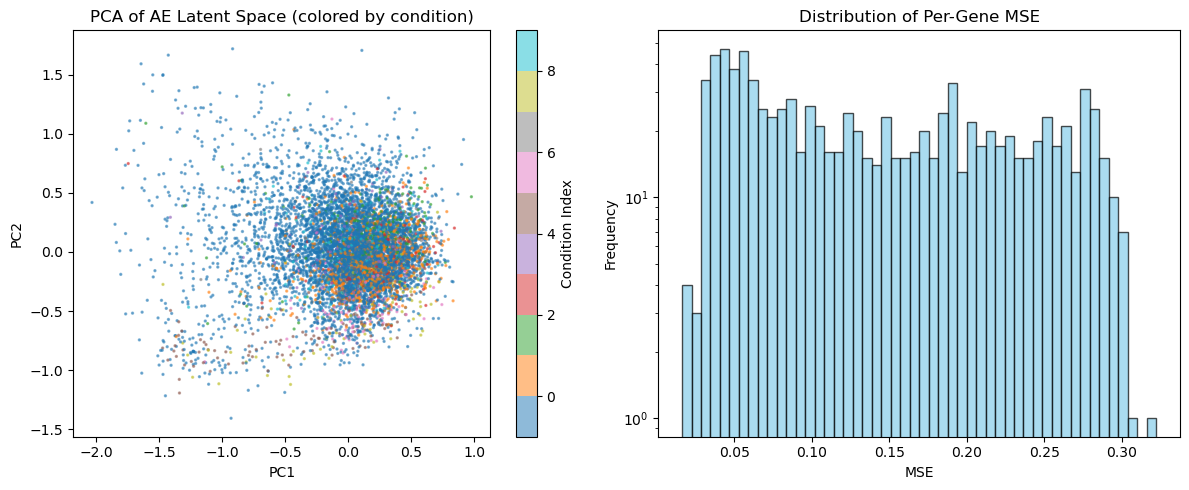


Reconstruction Statistics:
Overall MSE: 0.1460
Overall MAE: 0.2740
Mean per-gene MSE: 0.1460 ± 0.0834


In [ ]:
autoencoder.eval()
with torch.no_grad():
    X_test_tensor = test_dataset.dataset.tensors[0][test_dataset.indices]
    encoded_data = autoencoder.encoder(X_test_tensor).numpy()
    reconstructed = autoencoder(X_test_tensor).numpy()
    X_test_np = X_test_tensor.numpy()

print(f"Encoded shape: {encoded_data.shape}")

pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_data)

test_indices = test_dataset.indices
conditions = adata_single_top_genes.obs["condition_fixed"].iloc[test_indices].values
unique_conditions = pd.Series(conditions).value_counts().head(10).index

condition_to_color = {cond: i for i, cond in enumerate(unique_conditions)}
colors = [condition_to_color.get(cond, -1) for cond in conditions]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, cmap='tab10', alpha=0.5, s=2)
plt.title('PCA of AE Latent Space (colored by condition)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(scatter, label='Condition Index')

plt.subplot(1, 2, 2)
mse_per_sample = mean_squared_error(X_test_np, reconstructed, multioutput='raw_values')
plt.hist(mse_per_sample, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Per-Gene MSE')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.yscale('log')

plt.tight_layout()
plt.show()

print(f"\nReconstruction Statistics:")
print(f"Overall MSE: {mean_squared_error(X_test_np, reconstructed):.4f}")
print(f"Overall MAE: {mean_absolute_error(X_test_np, reconstructed):.4f}")
print(f"Mean per-gene MSE: {mse_per_sample.mean():.4f} ± {mse_per_sample.std():.4f}")

## 4. Improved Variational Autoencoder (VAE)

We implement an improved VAE with better architecture, KL annealing, and proper validation to learn a smooth latent space, which is better for generative tasks.

In [7]:
vae = ImprovedVAE(in_features=feature_dim, latent_dim=64, learning_rate=1e-3, 
                  kl_weight=0.1, kl_annealing=True)

early_stop_vae = EarlyStopping(monitor="val_loss", patience=5, mode="min")
checkpoint_vae = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, 
                                 filename="best-{epoch:02d}-{val_loss:.4f}")

logger_vae = CSVLogger(save_dir="lightning_logs", name="vae_experiment")
trainer_vae = pl.Trainer(
    max_epochs=50, 
    logger=logger_vae, 
    accelerator="auto",
    devices="auto",
    callbacks=[early_stop_vae, checkpoint_vae],
    enable_progress_bar=True
)
trainer_vae.fit(model=vae, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 289 K  | train
1 | fc_mu   | Linear     | 8.3 K  | train
2 | fc_var  | Linear     | 8.3 K  | train
3 | decoder | Sequential | 299 K  | train
-----------------------------------------------
605 K     Trainable params
0         Non-trainable params
605 K     Total params
2.422     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 5: 100%|██████████| 305/305 [00:05<00:00, 51.38it/s, v_num=2, val_loss=0.164, train_loss=0.169, recon_loss=0.164, kl_loss=0.246]


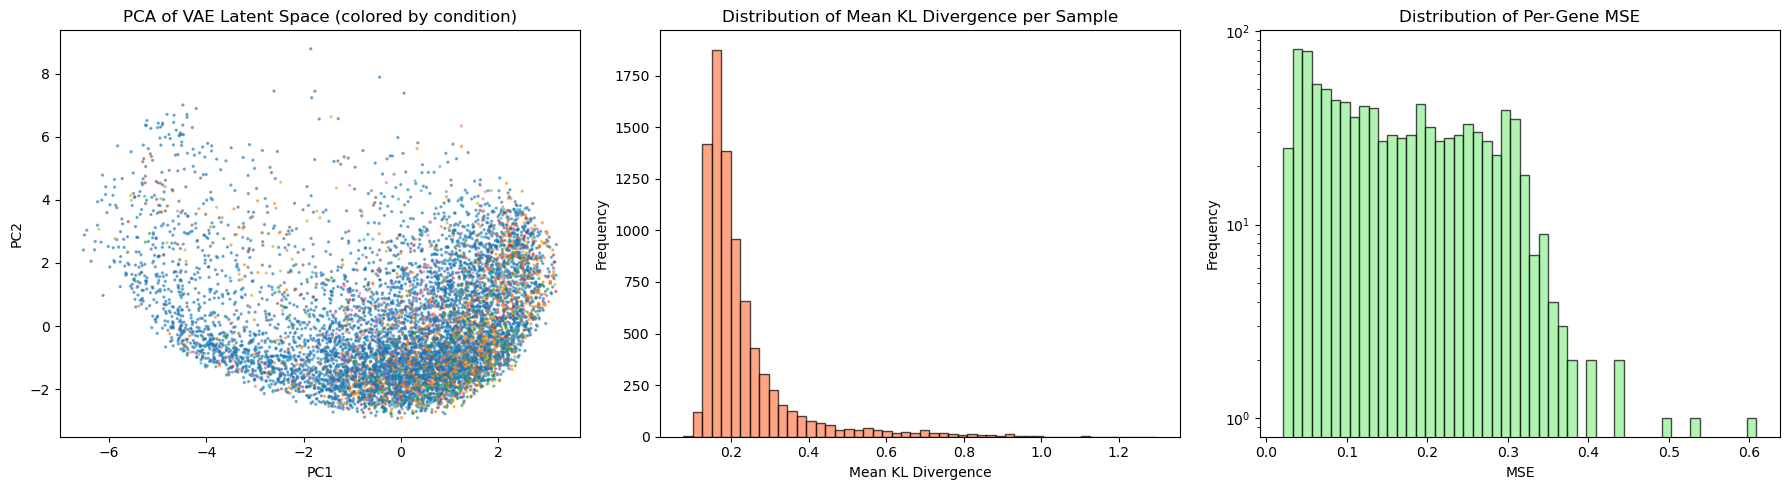


VAE Evaluation Statistics:
Overall MSE: 0.1593
Overall MAE: 0.2880
Mean KL Divergence: 0.2250 ± 0.4528
Mean per-gene MSE: 0.1593 ± 0.0970


In [8]:
vae.eval()
with torch.no_grad():
    X_test_tensor = test_dataset.dataset.tensors[0][test_dataset.indices]
    mu, log_var = vae.encode(X_test_tensor)
    z = mu.numpy()
    reconstructed, _, _ = vae(X_test_tensor)
    reconstructed_np = reconstructed.numpy()
    X_test_np = X_test_tensor.numpy()

test_indices = test_dataset.indices
conditions = adata_single_top_genes.obs["condition_fixed"].iloc[test_indices].values
unique_conditions = pd.Series(conditions).value_counts().head(10).index
condition_to_color = {cond: i for i, cond in enumerate(unique_conditions)}
colors = [condition_to_color.get(cond, -1) for cond in conditions]

pca_vae = PCA(n_components=2)
z_pca = pca_vae.fit_transform(z)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(z_pca[:, 0], z_pca[:, 1], c=colors, cmap='tab10', alpha=0.5, s=2)
axes[0].set_title('PCA of VAE Latent Space (colored by condition)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')

kl_div = -0.5 * (1 + log_var.numpy() - mu.numpy()**2 - np.exp(log_var.numpy()))
kl_mean_per_sample = kl_div.mean(axis=1)
axes[1].hist(kl_mean_per_sample, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Mean KL Divergence per Sample')
axes[1].set_xlabel('Mean KL Divergence')
axes[1].set_ylabel('Frequency')

mse_per_gene = mean_squared_error(X_test_np, reconstructed_np, multioutput='raw_values')
axes[2].hist(mse_per_gene, bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].set_title('Distribution of Per-Gene MSE')
axes[2].set_xlabel('MSE')
axes[2].set_ylabel('Frequency')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\nVAE Evaluation Statistics:")
print(f"Overall MSE: {mean_squared_error(X_test_np, reconstructed_np):.4f}")
print(f"Overall MAE: {mean_absolute_error(X_test_np, reconstructed_np):.4f}")
print(f"Mean KL Divergence: {kl_div.mean():.4f} ± {kl_div.std():.4f}")
print(f"Mean per-gene MSE: {mse_per_gene.mean():.4f} ± {mse_per_gene.std():.4f}")

## 5. Improved Generative Adversarial Network (GAN)

We implement an improved GAN with better architecture, gradient penalty (WGAN-GP style), and proper validation to generate synthetic gene expression profiles that mimic the real data.

In [11]:
gan = models.GAN(in_features=feature_dim, latent_dim=64, learning_rate=2e-4)

checkpoint_gan = ModelCheckpoint(monitor="val_d_loss", mode="min", save_top_k=1, 
                                 filename="best-{epoch:02d}-{val_d_loss:.4f}")

logger_gan = CSVLogger(save_dir="lightning_logs", name="gan_experiment")
trainer_gan = pl.Trainer(
    max_epochs=100,
    logger=logger_gan, 
    accelerator="auto",
    devices="auto",
    callbacks=[checkpoint_gan],
    enable_progress_bar=True
)
trainer_gan.fit(model=gan, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 686 K  | train
1 | discriminator | Discriminator | 676 K  | train
--------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.455     Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 99: 100%|██████████| 305/305 [00:34<00:00,  8.74it/s, v_num=7, val_d_loss=0.350, val_g_loss=1.300, g_loss=1.450, d_loss=0.451]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 305/305 [00:34<00:00,  8.73it/s, v_num=7, val_d_loss=0.350, val_g_loss=1.300, g_loss=1.450, d_loss=0.451]


Loading GAN model from checkpoint: /Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/lightning_logs/gan_experiment/version_7/checkpoints/best-epoch=99-val_d_loss=0.3495.ckpt
Model loaded successfully!

Generated 8364 synthetic samples
Real data shape: (8364, 1000), Synthetic data shape: (8364, 1000)


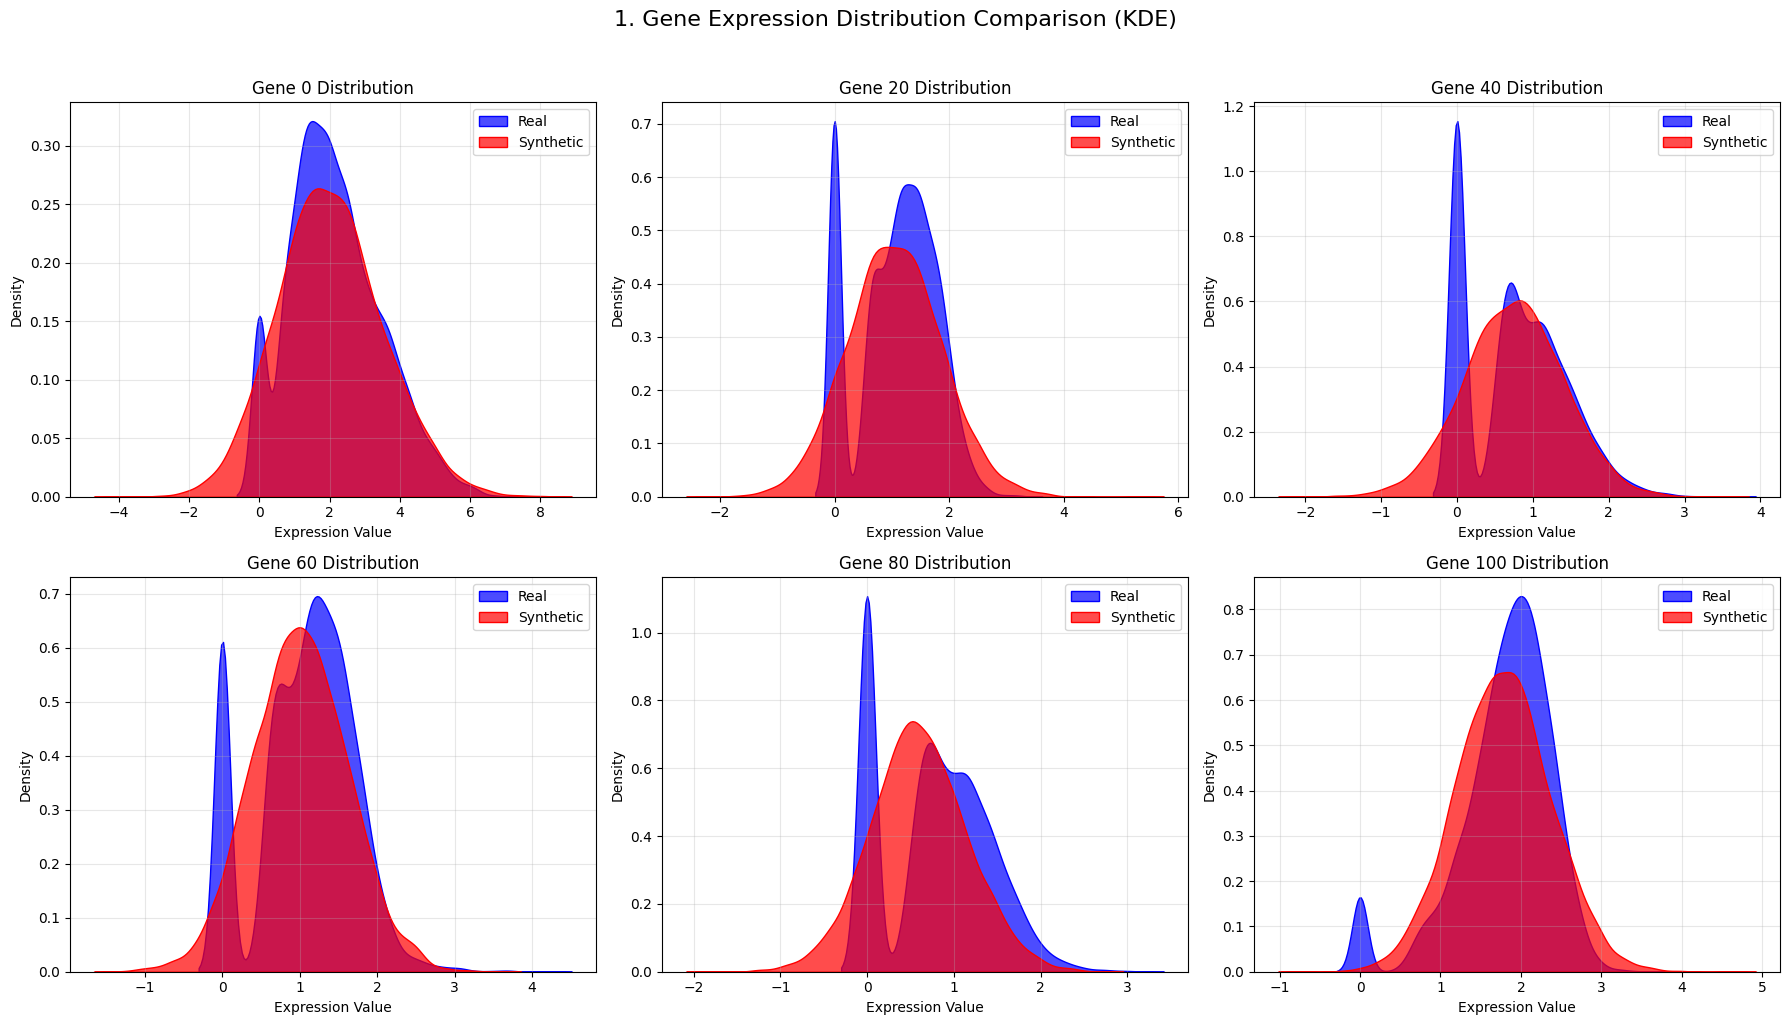


GAN Generation Statistics:
Real data mean: 0.5256 ± 0.8809
Synthetic data mean: 0.4937 ± 0.8249
Real data min/max: [0.0000, 8.4830]
Synthetic data min/max: [-3.9632, 9.5883]

Correlation between real and synthetic gene means: 0.9985 (p=0.00e+00)


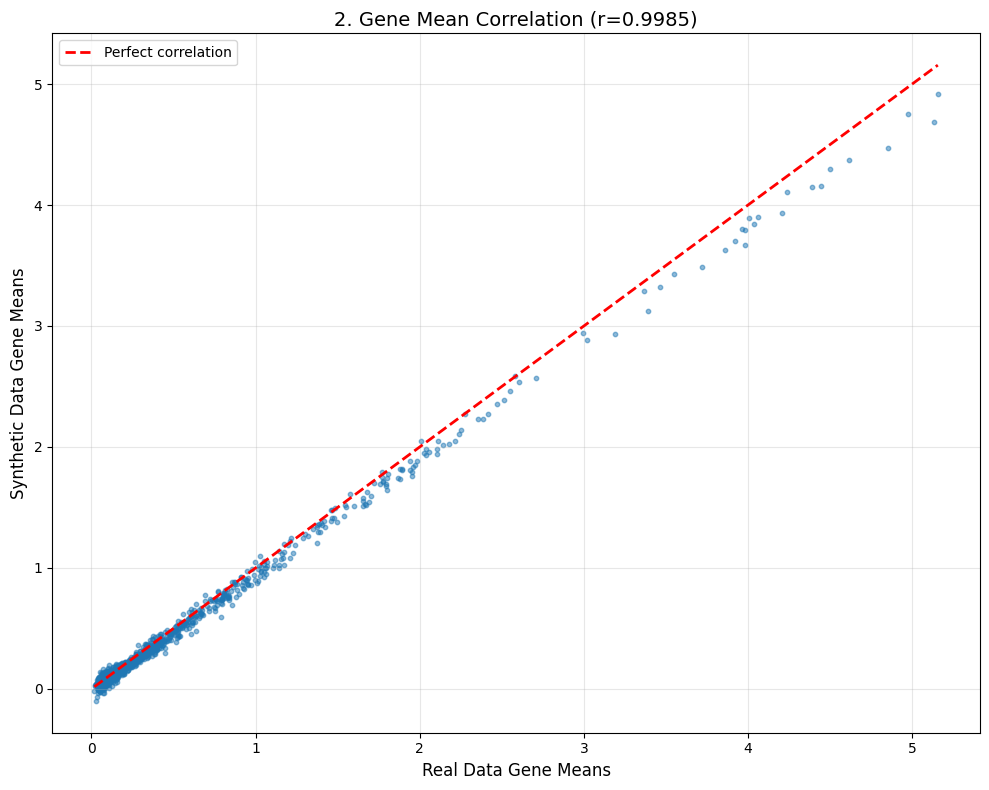

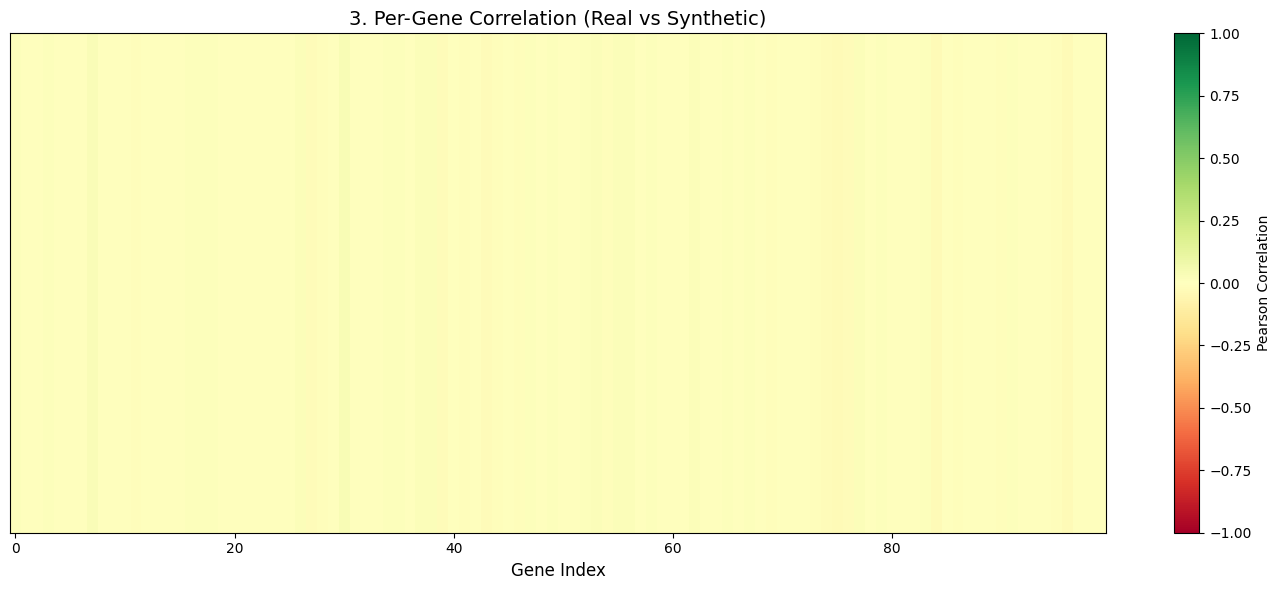


Per-gene correlation statistics:
  Mean: 0.0005 ± 0.0115
  Min: -0.0273, Max: 0.0340
  Genes with correlation > 0.9: 0/100


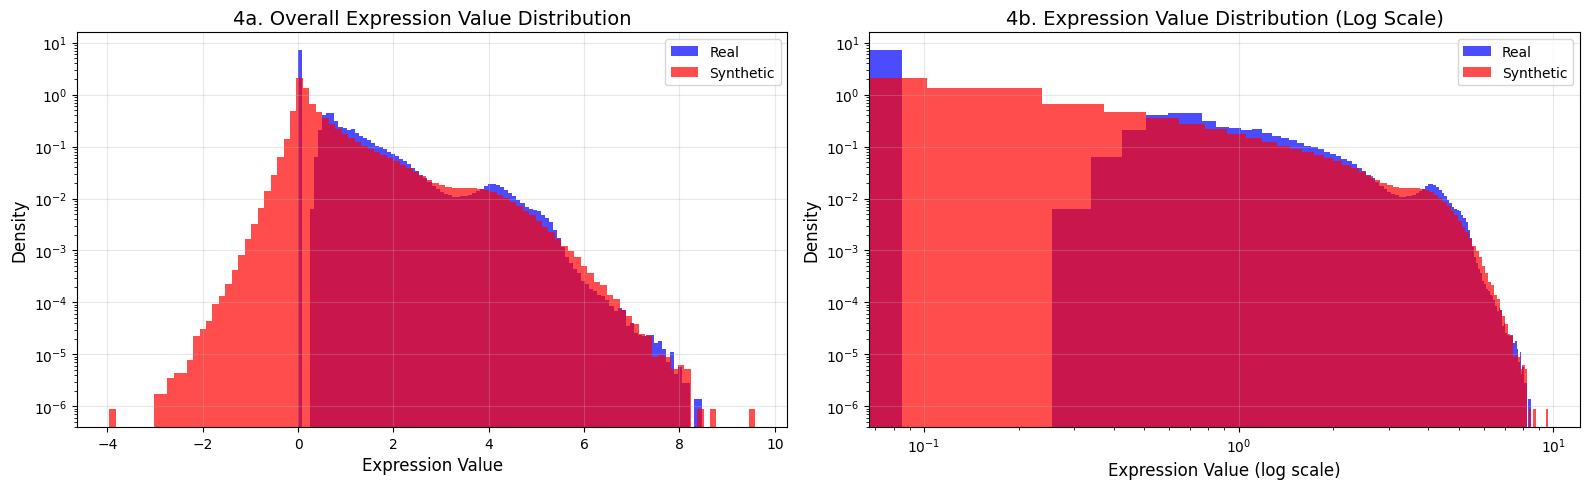

/var/folders/27/qmbdy4fs531c8887h6nfgych0000gn/T/ipykernel_64011/1402251454.py:149: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  zero_corr, zero_p = pearsonr(real_zeros, synth_zeros)


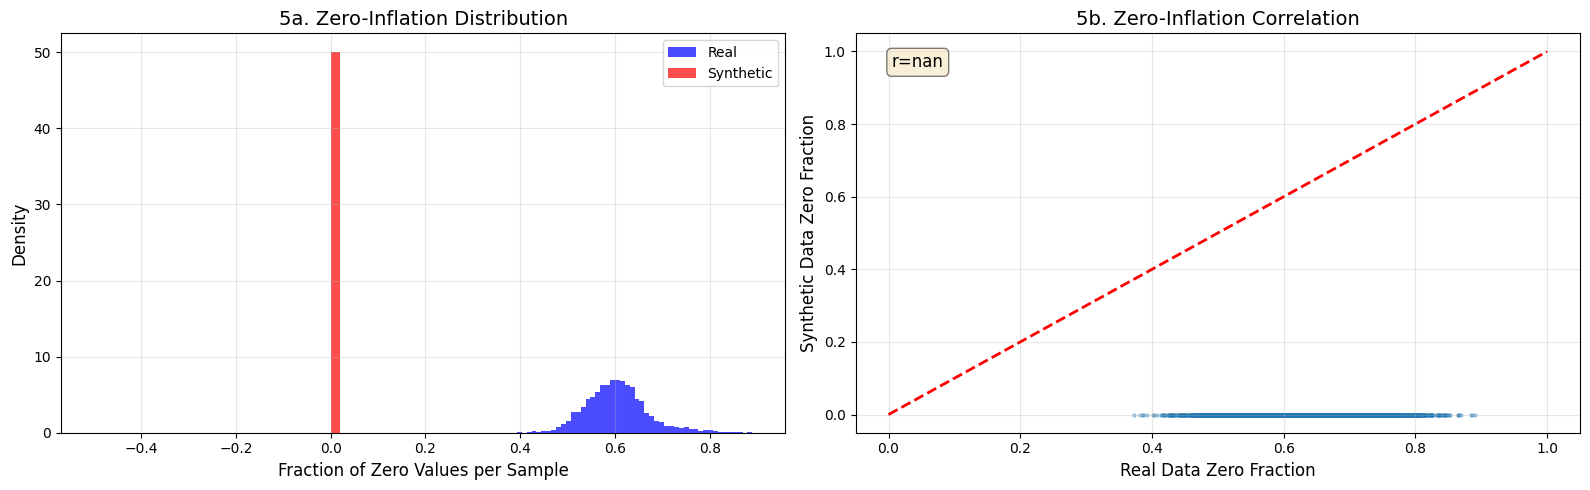


Zero-inflation statistics:
  Real data: 0.6040 ± 0.0657
  Synthetic data: 0.0000 ± 0.0000
  Correlation: nan (p=nan)


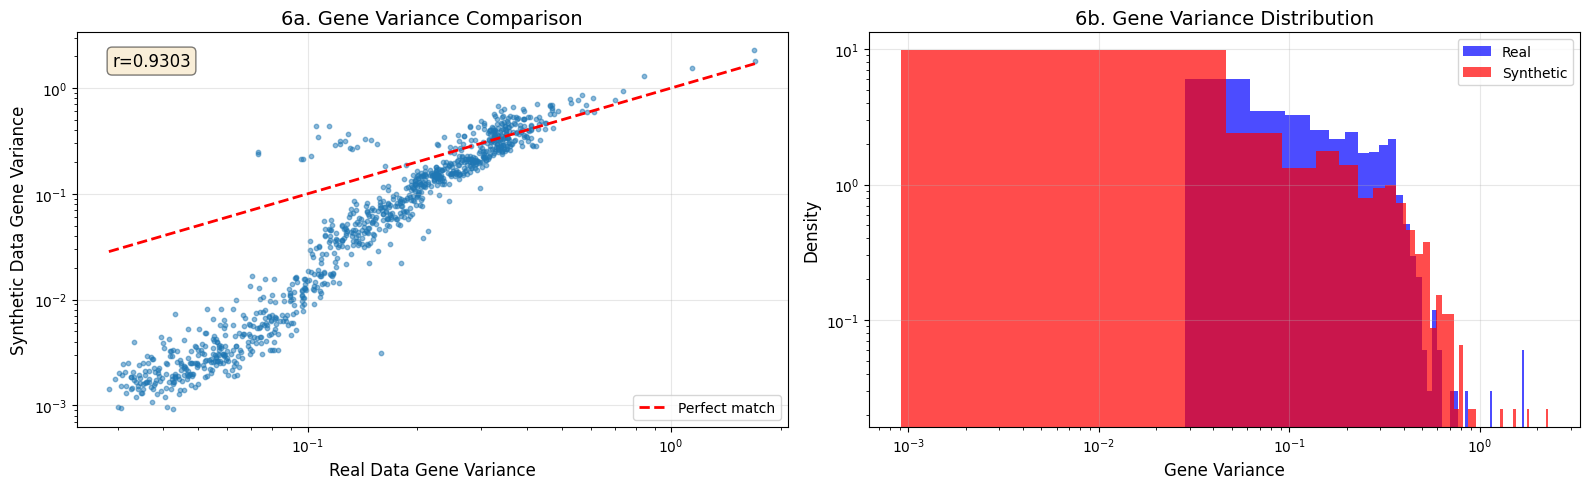


Variance statistics:
  Real data variance: 0.1867 ± 0.1447
  Synthetic data variance: 0.1447 ± 0.1959
  Correlation: 0.9303 (p=0.00e+00)


/var/folders/27/qmbdy4fs531c8887h6nfgych0000gn/T/ipykernel_64011/1402251454.py:229: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes[1].legend()
/var/folders/27/qmbdy4fs531c8887h6nfgych0000gn/T/ipykernel_64011/1402251454.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


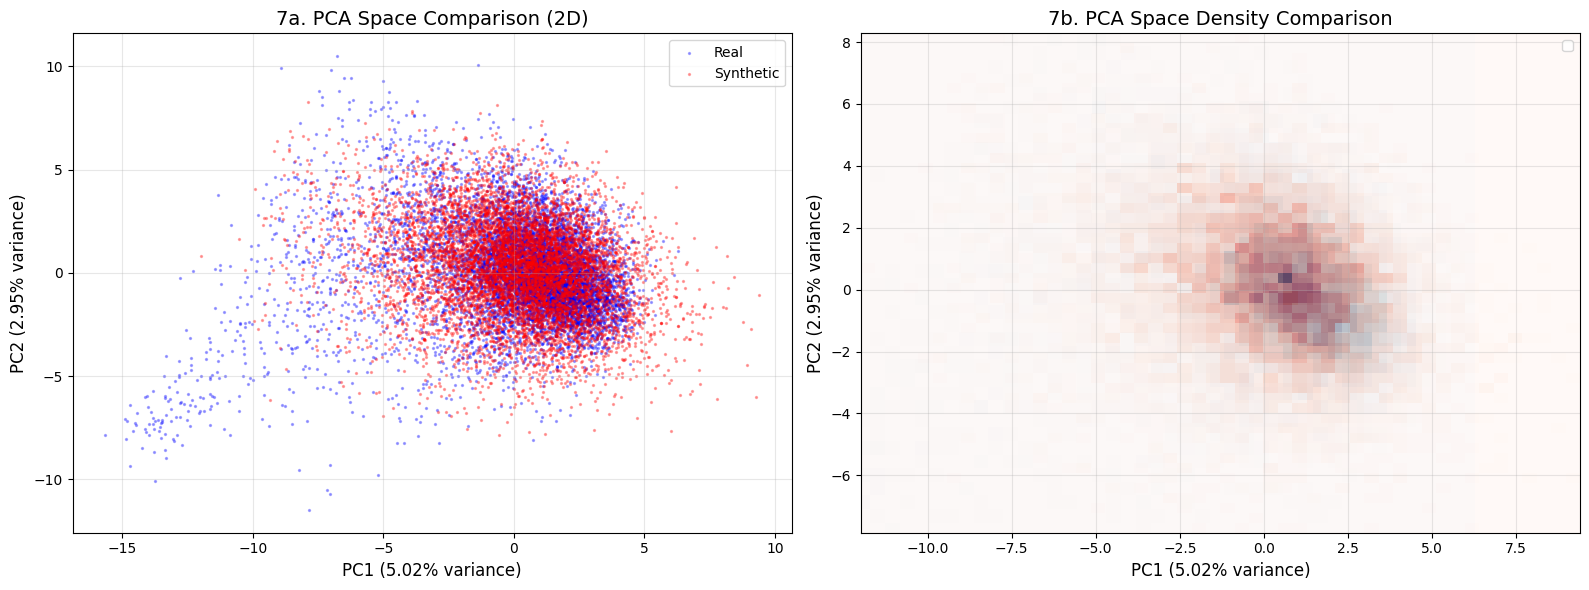


PCA explained variance:
  PC1: 0.0502
  PC2: 0.0295
  Total: 0.0796


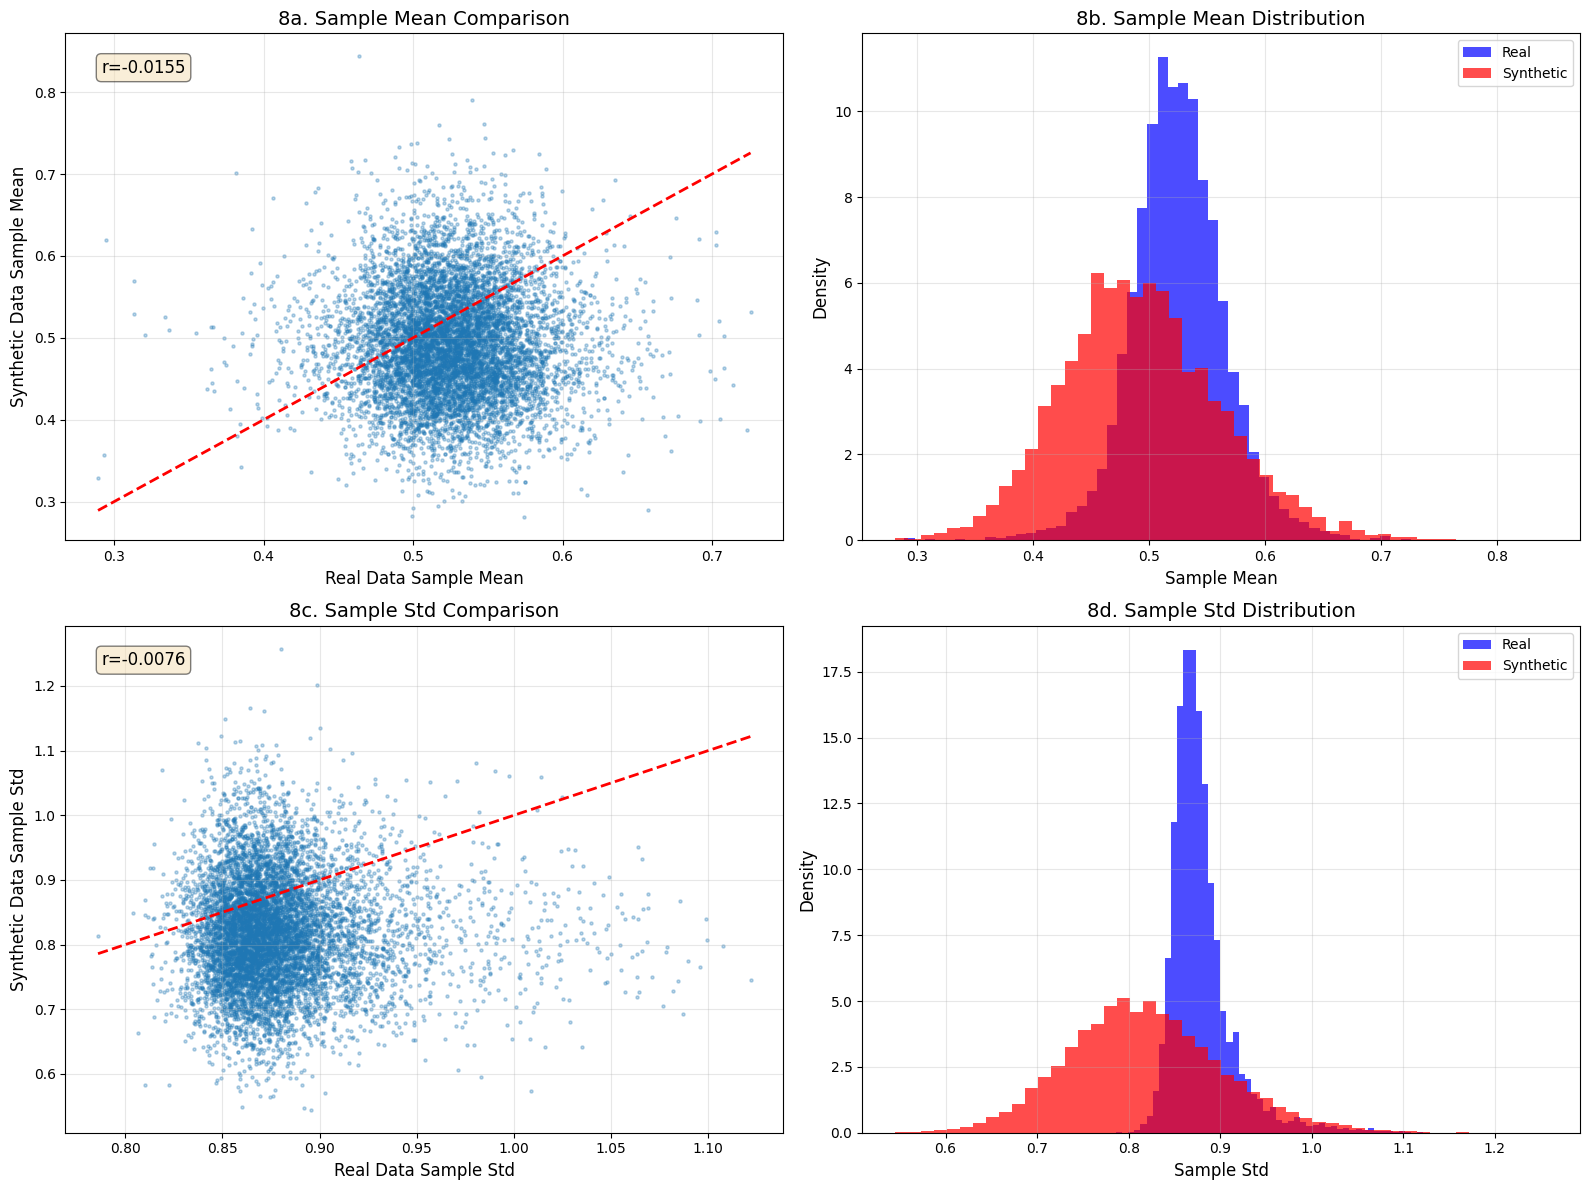


Sample-level statistics:
  Sample mean correlation: -0.0155
  Sample std correlation: -0.0076

COMPREHENSIVE GAN PERFORMANCE SUMMARY
Metric                                   Real Data            Synthetic Data      
----------------------------------------------------------------------
Overall Mean                             0.5256               0.4937              
Overall Std                              0.8809               0.8249              
Min Value                                0.0000               -3.9632             
Max Value                                8.4830               9.5883              
Zero Fraction                            0.6040               0.0000              
Gene Mean Correlation                                         0.9985              
Gene Variance Correlation                                     0.9303              
Zero-Inflation Correlation                                    nan                 
Sample Mean Correlation                         

In [9]:
# Load the trained GAN model from checkpoint
checkpoint_path = "/Users/amirrezaalasti/Desktop/master/semester 3/MLGenomic/amlg/src/projects/scrnaseq_project/lightning_logs/gan_experiment/version_7/checkpoints/best-epoch=99-val_d_loss=0.3495.ckpt"
print(f"Loading GAN model from checkpoint: {checkpoint_path}")

# Load the model with the correct hyperparameters
gan = models.GAN.load_from_checkpoint(checkpoint_path)
gan.eval()
print("Model loaded successfully!")

# Generate synthetic data using utility function
n_samples = len(test_dataset)
synthetic_data = evaluation.generate_synthetic_data(gan, n_samples, latent_dim=64)

X_test_tensor = test_dataset.dataset.tensors[0][test_dataset.indices]
real_data = X_test_tensor.numpy()

print(f"\nGenerated {n_samples} synthetic samples")
print(f"Real data shape: {real_data.shape}, Synthetic data shape: {synthetic_data.shape}")

# ============================================================================
# 1. Gene Distribution Comparison (KDE plots)
# ============================================================================
n_genes_to_plot = 6
gene_indices = np.linspace(0, min(100, feature_dim-1), n_genes_to_plot, dtype=int)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, gene_idx in enumerate(gene_indices):
    sns.kdeplot(real_data[:, gene_idx], label='Real', fill=True, ax=axes[i], alpha=0.7, color='blue')
    sns.kdeplot(synthetic_data[:, gene_idx], label='Synthetic', fill=True, ax=axes[i], alpha=0.7, color='red')
    axes[i].set_title(f'Gene {gene_idx} Distribution')
    axes[i].set_xlabel('Expression Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('1. Gene Expression Distribution Comparison (KDE)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# 2. Overall Statistics Comparison
# ============================================================================
print("\n" + "="*70)
print("GAN Generation Statistics:")
print("="*70)
print(f"Real data mean: {real_data.mean():.4f} ± {real_data.std():.4f}")
print(f"Synthetic data mean: {synthetic_data.mean():.4f} ± {synthetic_data.std():.4f}")
print(f"Real data min/max: [{real_data.min():.4f}, {real_data.max():.4f}]")
print(f"Synthetic data min/max: [{synthetic_data.min():.4f}, {synthetic_data.max():.4f}]")

real_means = real_data.mean(axis=0)
synth_means = synthetic_data.mean(axis=0)
correlation, p_value = pearsonr(real_means, synth_means)
print(f"\nCorrelation between real and synthetic gene means: {correlation:.4f} (p={p_value:.2e})")

# ============================================================================
# 3. Gene Mean Correlation Scatter Plot
# ============================================================================
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(real_means, synth_means, alpha=0.5, s=10)
ax.plot([real_means.min(), real_means.max()], [real_means.min(), real_means.max()], 
        'r--', lw=2, label='Perfect correlation')
ax.set_xlabel('Real Data Gene Means', fontsize=12)
ax.set_ylabel('Synthetic Data Gene Means', fontsize=12)
ax.set_title(f'2. Gene Mean Correlation (r={correlation:.4f})', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 4. Per-Gene Correlation Heatmap
# ============================================================================
# Calculate correlation for each gene
gene_correlations = []
for i in range(min(100, feature_dim)):  # Limit to first 100 genes for visualization
    corr, _ = pearsonr(real_data[:, i], synthetic_data[:, i])
    gene_correlations.append(corr)

gene_correlations = np.array(gene_correlations)

fig, ax = plt.subplots(1, 1, figsize=(14, 6))
im = ax.imshow(gene_correlations.reshape(1, -1), aspect='auto', cmap='RdYlGn', vmin=-1, vmax=1)
ax.set_xlabel('Gene Index', fontsize=12)
ax.set_title('3. Per-Gene Correlation (Real vs Synthetic)', fontsize=14)
ax.set_yticks([])
plt.colorbar(im, ax=ax, label='Pearson Correlation')
plt.tight_layout()
plt.show()

print(f"\nPer-gene correlation statistics:")
print(f"  Mean: {gene_correlations.mean():.4f} ± {gene_correlations.std():.4f}")
print(f"  Min: {gene_correlations.min():.4f}, Max: {gene_correlations.max():.4f}")
print(f"  Genes with correlation > 0.9: {(gene_correlations > 0.9).sum()}/{len(gene_correlations)}")

# ============================================================================
# 5. Distribution of Expression Values (Histogram)
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(real_data.flatten(), bins=100, alpha=0.7, label='Real', color='blue', density=True)
axes[0].hist(synthetic_data.flatten(), bins=100, alpha=0.7, label='Synthetic', color='red', density=True)
axes[0].set_xlabel('Expression Value', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('4a. Overall Expression Value Distribution', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Log scale for better visualization
axes[1].hist(real_data.flatten(), bins=100, alpha=0.7, label='Real', color='blue', density=True)
axes[1].hist(synthetic_data.flatten(), bins=100, alpha=0.7, label='Synthetic', color='red', density=True)
axes[1].set_xlabel('Expression Value (log scale)', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('4b. Expression Value Distribution (Log Scale)', fontsize=14)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# 6. Zero-Inflation Analysis (Important for scRNA-seq)
# ============================================================================
real_zeros = (real_data == 0).sum(axis=1) / real_data.shape[1]
synth_zeros = (synthetic_data == 0).sum(axis=1) / synthetic_data.shape[1]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].hist(real_zeros, bins=50, alpha=0.7, label='Real', color='blue', density=True)
axes[0].hist(synth_zeros, bins=50, alpha=0.7, label='Synthetic', color='red', density=True)
axes[0].set_xlabel('Fraction of Zero Values per Sample', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('5a. Zero-Inflation Distribution', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(real_zeros, synth_zeros, alpha=0.3, s=5)
axes[1].plot([0, 1], [0, 1], 'r--', lw=2)
axes[1].set_xlabel('Real Data Zero Fraction', fontsize=12)
axes[1].set_ylabel('Synthetic Data Zero Fraction', fontsize=12)
axes[1].set_title('5b. Zero-Inflation Correlation', fontsize=14)
axes[1].grid(True, alpha=0.3)

zero_corr, zero_p = pearsonr(real_zeros, synth_zeros)
axes[1].text(0.05, 0.95, f'r={zero_corr:.4f}', transform=axes[1].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nZero-inflation statistics:")
print(f"  Real data: {real_zeros.mean():.4f} ± {real_zeros.std():.4f}")
print(f"  Synthetic data: {synth_zeros.mean():.4f} ± {synth_zeros.std():.4f}")
print(f"  Correlation: {zero_corr:.4f} (p={zero_p:.2e})")

# ============================================================================
# 7. Variance Comparison
# ============================================================================
real_vars = real_data.var(axis=0)
synth_vars = synthetic_data.var(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

axes[0].scatter(real_vars, synth_vars, alpha=0.5, s=10)
axes[0].plot([real_vars.min(), real_vars.max()], [real_vars.min(), real_vars.max()], 
             'r--', lw=2, label='Perfect match')
axes[0].set_xlabel('Real Data Gene Variance', fontsize=12)
axes[0].set_ylabel('Synthetic Data Gene Variance', fontsize=12)
axes[0].set_title('6a. Gene Variance Comparison', fontsize=14)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

var_corr, var_p = pearsonr(real_vars, synth_vars)
axes[0].text(0.05, 0.95, f'r={var_corr:.4f}', transform=axes[0].transAxes, 
             fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1].hist(real_vars, bins=50, alpha=0.7, label='Real', color='blue', density=True)
axes[1].hist(synth_vars, bins=50, alpha=0.7, label='Synthetic', color='red', density=True)
axes[1].set_xlabel('Gene Variance', fontsize=12)
axes[1].set_ylabel('Density', fontsize=12)
axes[1].set_title('6b. Gene Variance Distribution', fontsize=14)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVariance statistics:")
print(f"  Real data variance: {real_vars.mean():.4f} ± {real_vars.std():.4f}")
print(f"  Synthetic data variance: {synth_vars.mean():.4f} ± {synth_vars.std():.4f}")
print(f"  Correlation: {var_corr:.4f} (p={var_p:.2e})")

# ============================================================================
# 8. PCA Comparison
# ============================================================================
from sklearn.decomposition import PCA

# Fit PCA on real data, transform both
pca = PCA(n_components=2)
pca.fit(real_data)
real_pca = pca.transform(real_data)
synth_pca = pca.transform(synthetic_data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.3, s=2, label='Real', color='blue')
axes[0].scatter(synth_pca[:, 0], synth_pca[:, 1], alpha=0.3, s=2, label='Synthetic', color='red')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0].set_title('7a. PCA Space Comparison (2D)', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Density plot
axes[1].hist2d(real_pca[:, 0], real_pca[:, 1], bins=50, cmap='Blues', alpha=0.7, label='Real')
axes[1].hist2d(synth_pca[:, 0], synth_pca[:, 1], bins=50, cmap='Reds', alpha=0.5, label='Synthetic')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[1].set_title('7b. PCA Space Density Comparison', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPCA explained variance:")
print(f"  PC1: {pca.explained_variance_ratio_[0]:.4f}")
print(f"  PC2: {pca.explained_variance_ratio_[1]:.4f}")
print(f"  Total: {pca.explained_variance_ratio_[:2].sum():.4f}")

# ============================================================================
# 9. Sample-level Statistics Comparison
# ============================================================================
real_sample_means = real_data.mean(axis=1)
synth_sample_means = synthetic_data.mean(axis=1)
real_sample_stds = real_data.std(axis=1)
synth_sample_stds = synthetic_data.std(axis=1)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sample means
axes[0, 0].scatter(real_sample_means, synth_sample_means, alpha=0.3, s=5)
axes[0, 0].plot([real_sample_means.min(), real_sample_means.max()], 
                [real_sample_means.min(), real_sample_means.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Real Data Sample Mean', fontsize=12)
axes[0, 0].set_ylabel('Synthetic Data Sample Mean', fontsize=12)
axes[0, 0].set_title('8a. Sample Mean Comparison', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)
mean_corr, _ = pearsonr(real_sample_means, synth_sample_means)
axes[0, 0].text(0.05, 0.95, f'r={mean_corr:.4f}', transform=axes[0, 0].transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[0, 1].hist(real_sample_means, bins=50, alpha=0.7, label='Real', color='blue', density=True)
axes[0, 1].hist(synth_sample_means, bins=50, alpha=0.7, label='Synthetic', color='red', density=True)
axes[0, 1].set_xlabel('Sample Mean', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].set_title('8b. Sample Mean Distribution', fontsize=14)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Sample stds
axes[1, 0].scatter(real_sample_stds, synth_sample_stds, alpha=0.3, s=5)
axes[1, 0].plot([real_sample_stds.min(), real_sample_stds.max()], 
                [real_sample_stds.min(), real_sample_stds.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Real Data Sample Std', fontsize=12)
axes[1, 0].set_ylabel('Synthetic Data Sample Std', fontsize=12)
axes[1, 0].set_title('8c. Sample Std Comparison', fontsize=14)
axes[1, 0].grid(True, alpha=0.3)
std_corr, _ = pearsonr(real_sample_stds, synth_sample_stds)
axes[1, 0].text(0.05, 0.95, f'r={std_corr:.4f}', transform=axes[1, 0].transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[1, 1].hist(real_sample_stds, bins=50, alpha=0.7, label='Real', color='blue', density=True)
axes[1, 1].hist(synth_sample_stds, bins=50, alpha=0.7, label='Synthetic', color='red', density=True)
axes[1, 1].set_xlabel('Sample Std', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].set_title('8d. Sample Std Distribution', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSample-level statistics:")
print(f"  Sample mean correlation: {mean_corr:.4f}")
print(f"  Sample std correlation: {std_corr:.4f}")

# ============================================================================
# 10. Summary Statistics Table
# ============================================================================
print("\n" + "="*70)
print("COMPREHENSIVE GAN PERFORMANCE SUMMARY")
print("="*70)
print(f"{'Metric':<40} {'Real Data':<20} {'Synthetic Data':<20}")
print("-"*70)
print(f"{'Overall Mean':<40} {real_data.mean():<20.4f} {synthetic_data.mean():<20.4f}")
print(f"{'Overall Std':<40} {real_data.std():<20.4f} {synthetic_data.std():<20.4f}")
print(f"{'Min Value':<40} {real_data.min():<20.4f} {synthetic_data.min():<20.4f}")
print(f"{'Max Value':<40} {real_data.max():<20.4f} {synthetic_data.max():<20.4f}")
print(f"{'Zero Fraction':<40} {(real_data == 0).mean():<20.4f} {(synthetic_data == 0).mean():<20.4f}")
print(f"{'Gene Mean Correlation':<40} {'':<20} {correlation:<20.4f}")
print(f"{'Gene Variance Correlation':<40} {'':<20} {var_corr:<20.4f}")
print(f"{'Zero-Inflation Correlation':<40} {'':<20} {zero_corr:<20.4f}")
print(f"{'Sample Mean Correlation':<40} {'':<20} {mean_corr:<20.4f}")
print(f"{'Sample Std Correlation':<40} {'':<20} {std_corr:<20.4f}")
print("="*70)

/var/folders/27/qmbdy4fs531c8887h6nfgych0000gn/T/ipykernel_64011/285915935.py:39: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  axes[1, 0].legend()
/var/folders/27/qmbdy4fs531c8887h6nfgych0000gn/T/ipykernel_64011/285915935.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1, 0].legend()


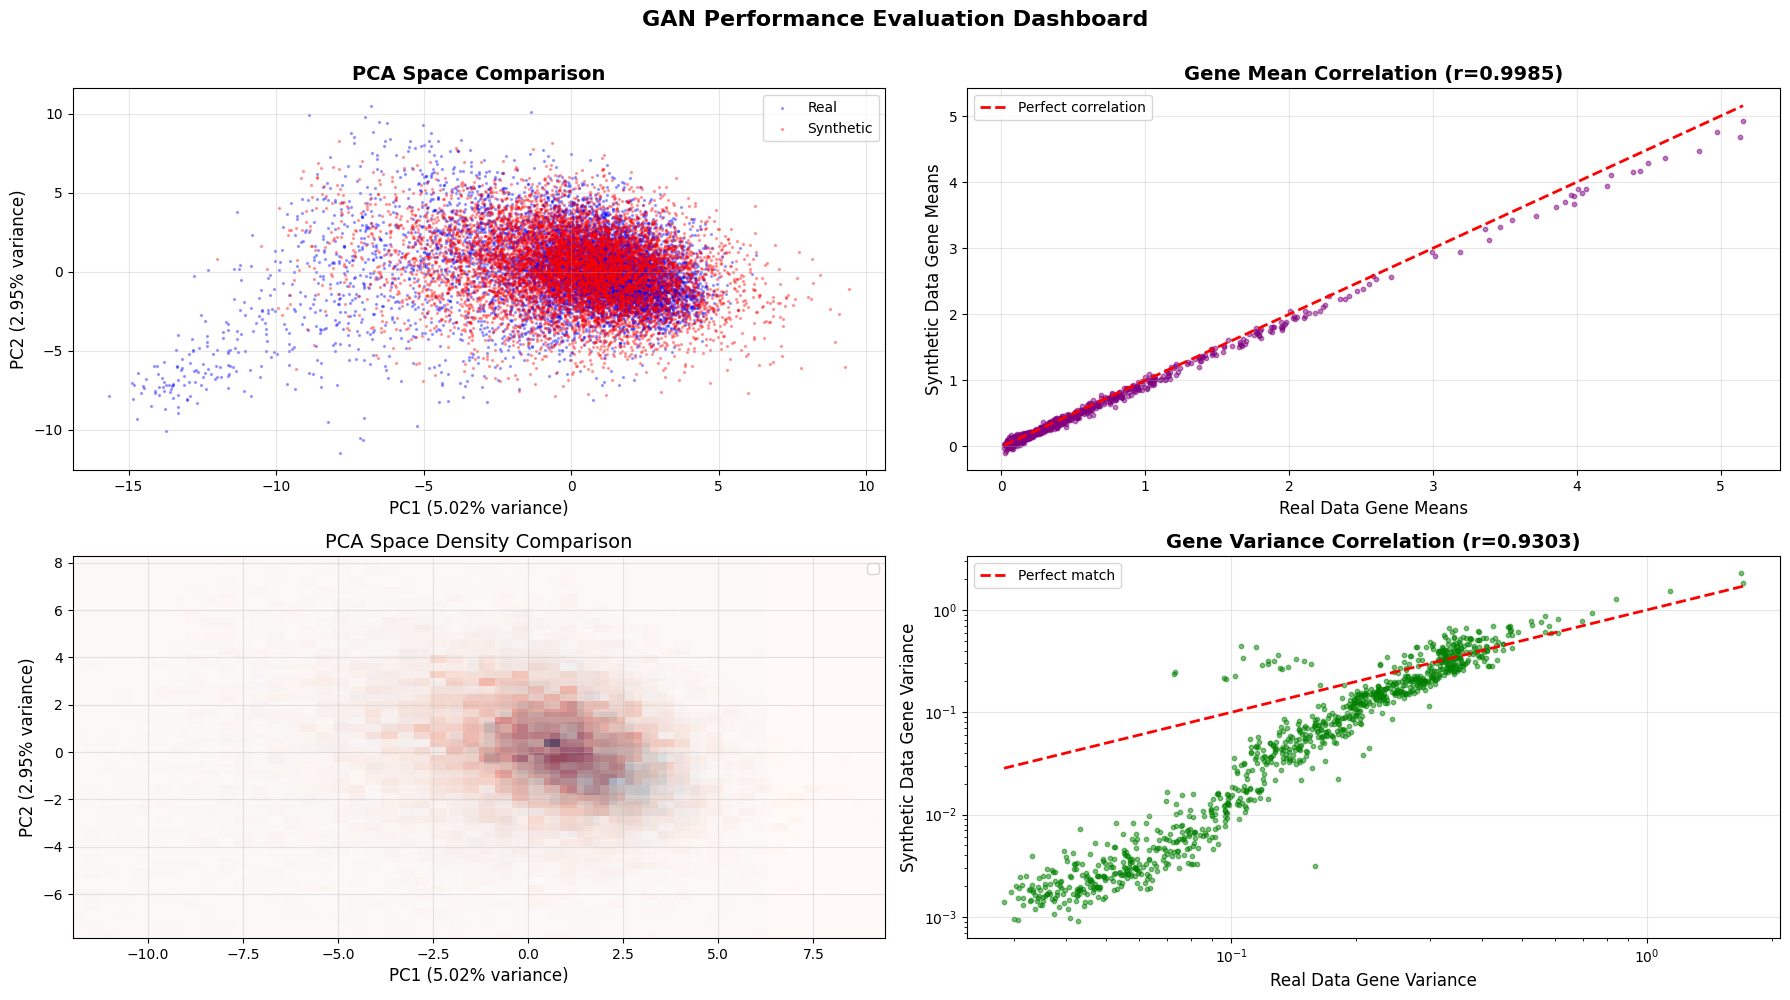

In [12]:
# ============================================================================
# Comprehensive GAN Performance Visualization (2x2 Grid)
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# 1. PCA Space Comparison (Top Left)
axes[0, 0].scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.3, s=2, label='Real', color='blue')
axes[0, 0].scatter(synth_pca[:, 0], synth_pca[:, 1], alpha=0.3, s=2, label='Synthetic', color='red')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0, 0].set_title('PCA Space Comparison', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Gene Mean Correlation (Top Right)
axes[0, 1].scatter(real_means, synth_means, alpha=0.5, s=10, color='purple')
axes[0, 1].plot([real_means.min(), real_means.max()], [real_means.min(), real_means.max()], 
                'r--', lw=2, label='Perfect correlation')
axes[0, 1].set_xlabel('Real Data Gene Means', fontsize=12)
axes[0, 1].set_ylabel('Synthetic Data Gene Means', fontsize=12)
axes[0, 1].set_title(f'Gene Mean Correlation (r={correlation:.4f})', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. Zero-Inflation Correlation (Bottom Left)
# axes[1, 0].scatter(real_zeros, synth_zeros, alpha=0.3, s=5, color='orange')
# axes[1, 0].plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect match')
# axes[1, 0].set_xlabel('Real Data Zero Fraction', fontsize=12)
# axes[1, 0].set_ylabel('Synthetic Data Zero Fraction', fontsize=12)
# axes[1, 0].set_title(f'Zero-Inflation Correlation (r={zero_corr:.4f})', fontsize=14, fontweight='bold')
# axes[1, 0].legend(fontsize=10)
# axes[1, 0].grid(True, alpha=0.3)

axes[1, 0].hist2d(real_pca[:, 0], real_pca[:, 1], bins=50, cmap='Blues', alpha=0.7, label='Real')
axes[1, 0].hist2d(synth_pca[:, 0], synth_pca[:, 1], bins=50, cmap='Reds', alpha=0.5, label='Synthetic')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[1, 0].set_title('PCA Space Density Comparison', fontsize=14)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Gene Variance Comparison (Bottom Right)
axes[1, 1].scatter(real_vars, synth_vars, alpha=0.5, s=10, color='green')
axes[1, 1].plot([real_vars.min(), real_vars.max()], [real_vars.min(), real_vars.max()], 
               'r--', lw=2, label='Perfect match')
axes[1, 1].set_xlabel('Real Data Gene Variance', fontsize=12)
axes[1, 1].set_ylabel('Synthetic Data Gene Variance', fontsize=12)
axes[1, 1].set_title(f'Gene Variance Correlation (r={var_corr:.4f})', fontsize=14, fontweight='bold')
axes[1, 1].set_xscale('log')
axes[1, 1].set_yscale('log')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('GAN Performance Evaluation Dashboard', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


## 6. Comprehensive Evaluation and Visualization

We evaluate the quality of all models by visualizing the latent spaces, computing comprehensive reconstruction metrics, and comparing model performances.

Computing PCA...
Computing UMAP...


/opt/anaconda3/envs/SMAC/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


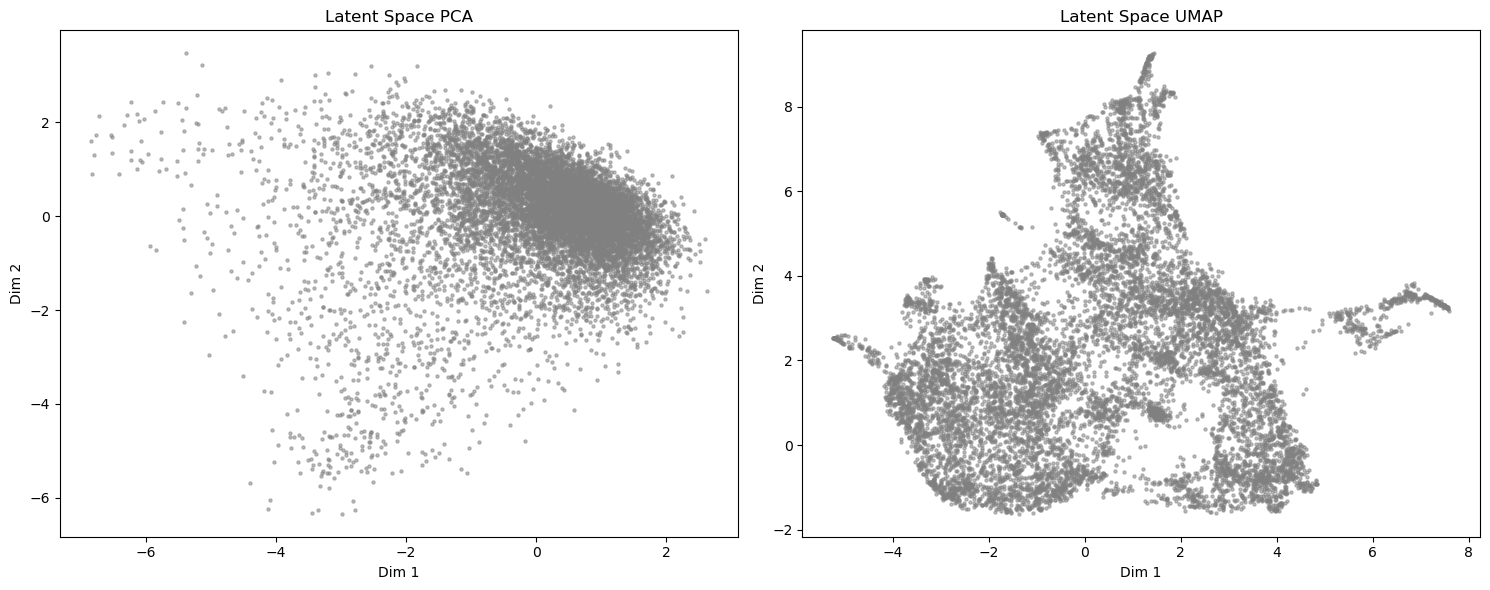

In [13]:
import umap
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Evaluate models using utility function
print("Evaluating Autoencoder...")
ae_results = evaluation.evaluate_model(autoencoder, test_loader, 'ae')

print("Evaluating VAE...")
vae_results = evaluation.evaluate_model(vae, test_loader, 'vae')

test_indices = test_dataset.indices
conditions = adata_single_top_genes.obs["condition_fixed"].iloc[test_indices].values
unique_conditions = pd.Series(conditions).value_counts().head(10).index
condition_to_color = {cond: i for i, cond in enumerate(unique_conditions)}
colors = [condition_to_color.get(cond, -1) for cond in conditions]

print("\nComputing UMAP embeddings...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=30, min_dist=0.1)

ae_umap = reducer.fit_transform(ae_results['latent'])
vae_umap = reducer.fit_transform(vae_results['latent'])

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

pca_ae = PCA(n_components=2)
ae_pca = pca_ae.fit_transform(ae_results['latent'])
axes[0, 0].scatter(ae_pca[:, 0], ae_pca[:, 1], c=colors, cmap='tab10', alpha=0.5, s=3)
axes[0, 0].set_title(f'AE Latent Space (PCA)\nR²={ae_results["r2"]:.4f}, MSE={ae_results["mse"]:.4f}')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')

axes[0, 1].scatter(ae_umap[:, 0], ae_umap[:, 1], c=colors, cmap='tab10', alpha=0.5, s=3)
axes[0, 1].set_title('AE Latent Space (UMAP)')
axes[0, 1].set_xlabel('UMAP 1')
axes[0, 1].set_ylabel('UMAP 2')

pca_vae = PCA(n_components=2)
vae_pca = pca_vae.fit_transform(vae_results['latent'])
axes[1, 0].scatter(vae_pca[:, 0], vae_pca[:, 1], c=colors, cmap='tab10', alpha=0.5, s=3)
axes[1, 0].set_title(f'VAE Latent Space (PCA)\nR²={vae_results["r2"]:.4f}, MSE={vae_results["mse"]:.4f}')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')

axes[1, 1].scatter(vae_umap[:, 0], vae_umap[:, 1], c=colors, cmap='tab10', alpha=0.5, s=3)
axes[1, 1].set_title('VAE Latent Space (UMAP)')
axes[1, 1].set_xlabel('UMAP 1')
axes[1, 1].set_ylabel('UMAP 2')

plt.tight_layout()
plt.show()

Overall Reconstruction R²: 0.1269


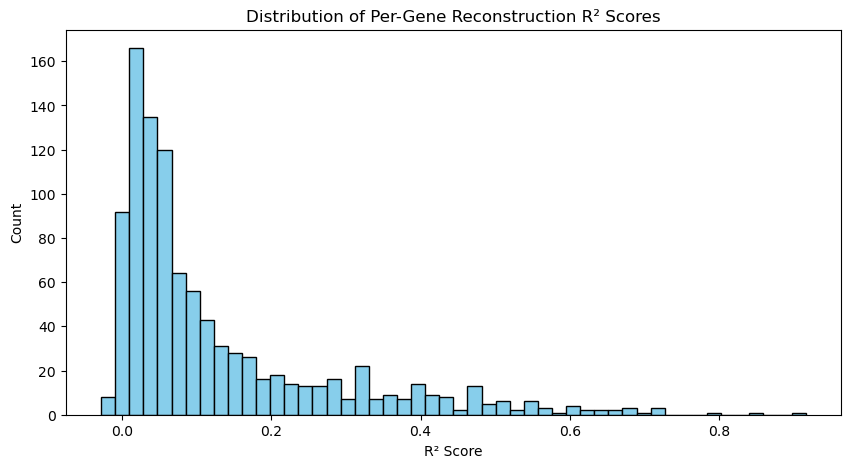

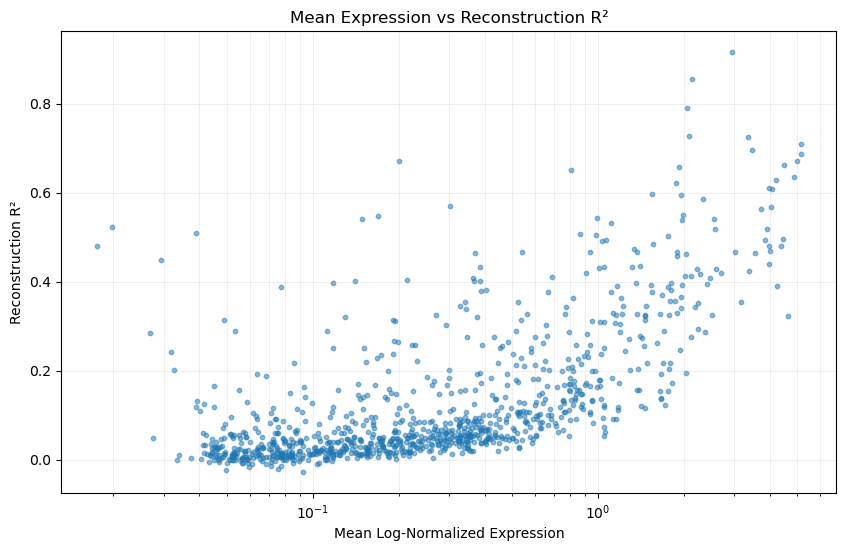

In [ ]:
# Final model testing on test set
print("\n" + "="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)

# Test all models
print("\nTesting Autoencoder on test set...")
trainer_ae.test(model=autoencoder, dataloaders=test_loader)

print("\nTesting VAE on test set...")
trainer_vae.test(model=vae, dataloaders=test_loader)

print("\nTesting GAN on test set...")
trainer_gan.test(model=gan, dataloaders=test_loader)

print("\n" + "="*60)
print("All models have been evaluated!")
print("="*60)


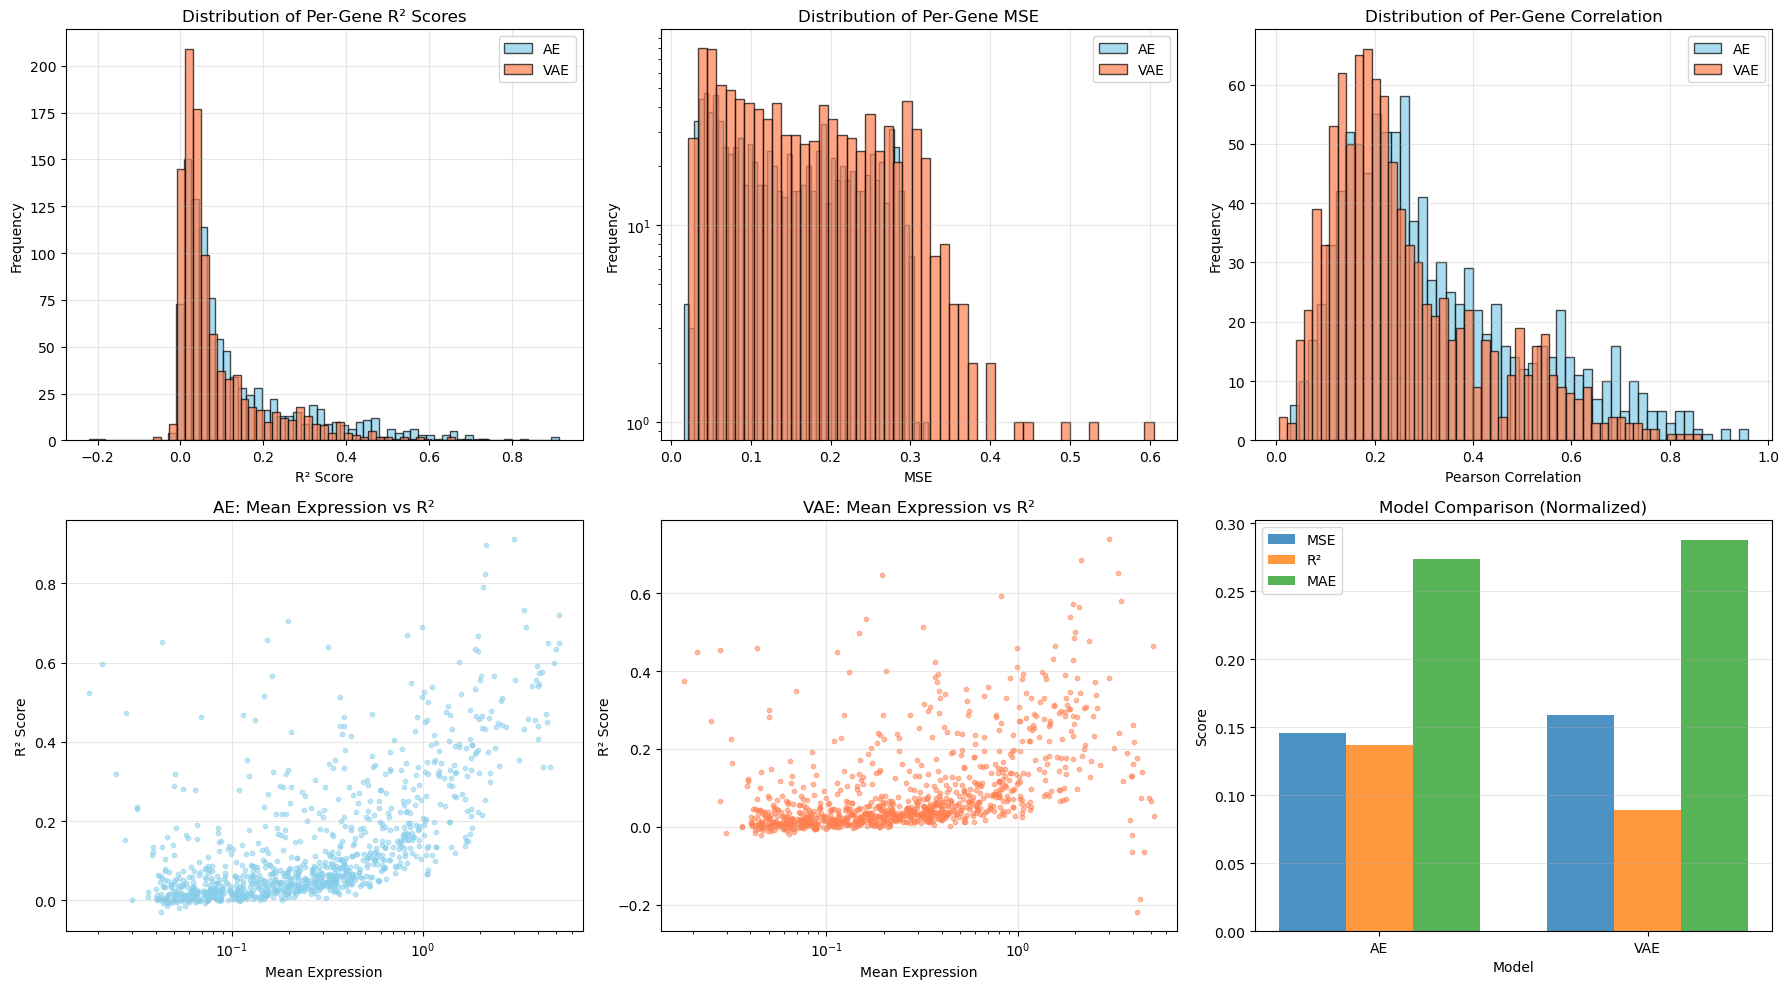


COMPREHENSIVE MODEL EVALUATION SUMMARY

Metric               AE                   VAE                 
------------------------------------------------------------
Overall MSE          0.1460               0.1593              
Overall MAE          0.2740               0.2879              
Overall R²           0.1372               0.0891              
Mean R² per gene     0.1372               0.0891              
Mean Corr per gene   0.3278               0.2654              
Std R² per gene      0.1586               0.1159              


In [15]:
# Comprehensive reconstruction analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. R² distribution comparison
axes[0, 0].hist(ae_results['r2_per_gene'], bins=50, alpha=0.7, label='AE', color='skyblue', edgecolor='black')
axes[0, 0].hist(vae_results['r2_per_gene'], bins=50, alpha=0.7, label='VAE', color='coral', edgecolor='black')
axes[0, 0].set_title('Distribution of Per-Gene R² Scores')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. MSE distribution comparison
axes[0, 1].hist(ae_results['mse_per_gene'], bins=50, alpha=0.7, label='AE', color='skyblue', edgecolor='black')
axes[0, 1].hist(vae_results['mse_per_gene'], bins=50, alpha=0.7, label='VAE', color='coral', edgecolor='black')
axes[0, 1].set_title('Distribution of Per-Gene MSE')
axes[0, 1].set_xlabel('MSE')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_yscale('log')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Correlation distribution comparison
axes[0, 2].hist(ae_results['corr_per_gene'], bins=50, alpha=0.7, label='AE', color='skyblue', edgecolor='black')
axes[0, 2].hist(vae_results['corr_per_gene'], bins=50, alpha=0.7, label='VAE', color='coral', edgecolor='black')
axes[0, 2].set_title('Distribution of Per-Gene Correlation')
axes[0, 2].set_xlabel('Pearson Correlation')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Mean expression vs R² (AE)
mean_expression = ae_results['original'].mean(axis=0)
axes[1, 0].scatter(mean_expression, ae_results['r2_per_gene'], alpha=0.5, s=10, color='skyblue')
axes[1, 0].set_title('AE: Mean Expression vs R²')
axes[1, 0].set_xlabel('Mean Expression')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].set_xscale('log')
axes[1, 0].grid(True, alpha=0.3)

# 5. Mean expression vs R² (VAE)
axes[1, 1].scatter(mean_expression, vae_results['r2_per_gene'], alpha=0.5, s=10, color='coral')
axes[1, 1].set_title('VAE: Mean Expression vs R²')
axes[1, 1].set_xlabel('Mean Expression')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

# 6. Model comparison summary
models = ['AE', 'VAE']
mse_scores = [ae_results['mse'], vae_results['mse']]
r2_scores = [ae_results['r2'], vae_results['r2']]
mae_scores = [ae_results['mae'], vae_results['mae']]

x = np.arange(len(models))
width = 0.25

axes[1, 2].bar(x - width, mse_scores, width, label='MSE', alpha=0.8)
axes[1, 2].bar(x, r2_scores, width, label='R²', alpha=0.8)
axes[1, 2].bar(x + width, mae_scores, width, label='MAE', alpha=0.8)
axes[1, 2].set_xlabel('Model')
axes[1, 2].set_ylabel('Score')
axes[1, 2].set_title('Model Comparison (Normalized)')
axes[1, 2].set_xticks(x)
axes[1, 2].set_xticklabels(models)
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comprehensive summary
print("\n" + "="*60)
print("COMPREHENSIVE MODEL EVALUATION SUMMARY")
print("="*60)
print(f"\n{'Metric':<20} {'AE':<20} {'VAE':<20}")
print("-"*60)
print(f"{'Overall MSE':<20} {ae_results['mse']:<20.4f} {vae_results['mse']:<20.4f}")
print(f"{'Overall MAE':<20} {ae_results['mae']:<20.4f} {vae_results['mae']:<20.4f}")
print(f"{'Overall R²':<20} {ae_results['r2']:<20.4f} {vae_results['r2']:<20.4f}")
print(f"{'Mean R² per gene':<20} {ae_results['r2_per_gene'].mean():<20.4f} {vae_results['r2_per_gene'].mean():<20.4f}")
print(f"{'Mean Corr per gene':<20} {ae_results['corr_per_gene'].mean():<20.4f} {vae_results['corr_per_gene'].mean():<20.4f}")
print(f"{'Std R² per gene':<20} {ae_results['r2_per_gene'].std():<20.4f} {vae_results['r2_per_gene'].std():<20.4f}")
print("="*60)